In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier


In [2]:
train_df = pd.read_csv('train_sessions.csv', index_col = 'session_id')
test_df = pd.read_csv('test_sessions.csv', index_col = 'session_id')
train_df

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253557,3474,2013-11-25 10:26:54,3474.0,2013-11-25 10:26:58,141.0,2013-11-25 10:27:03,2428.0,2013-11-25 10:27:04,106.0,2013-11-25 10:27:13,...,2013-11-25 10:27:16,2428.0,2013-11-25 10:27:28,2428.0,2013-11-25 10:27:40,2428.0,2013-11-25 10:27:52,148.0,2013-11-25 10:27:53,0
253558,12727,2013-03-12 16:01:15,12727.0,2013-03-12 16:01:16,2215.0,2013-03-12 16:01:16,38.0,2013-03-12 16:01:17,2215.0,2013-03-12 16:01:17,...,2013-03-12 16:01:17,25444.0,2013-03-12 16:01:18,2215.0,2013-03-12 16:01:18,23.0,2013-03-12 16:01:18,21.0,2013-03-12 16:01:18,0
253559,2661,2013-09-12 14:05:03,15004.0,2013-09-12 14:05:10,5562.0,2013-09-12 14:05:10,5562.0,2013-09-12 14:06:29,5562.0,2013-09-12 14:06:30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [3]:
train_df[train_df['target'] == 1].shape, train_df[train_df['target'] == 0].shape

((2297, 21), (251264, 21))

In [4]:
features = pd.DataFrame()

sites = train_df[['site%s' % i for i in range(1,11)]].fillna(0).astype(int).values
times = train_df[['time%s' % i for i in range(1,11)]]

for td_index in range(1, 10):
    features['target'] = train_df['target']
    features['time_diff{}'.format(td_index)] = (pd.to_datetime(times['time{}'.format(td_index + 1)]) - pd.to_datetime(times['time{}'.format(td_index)])).dt.total_seconds().fillna(0)
    
features['time_of_session'] = np.sum(features, axis = 1)
features['hour'] = pd.to_datetime(times['time1']).dt.hour
features['dow'] = pd.to_datetime(times['time1']).dt.dayofweek
features['month'] = pd.to_datetime(times['time1']).dt.month
features['unique_sites'] = [len(np.unique(session[session != 0])) for session in sites]

In [5]:
features['unique_sites'] = [len(np.unique(session[session != 0])) for session in sites]

In [6]:
features

,target,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,time_of_session,hour,dow,month,unique_sites
session_id,,,,,,,,,,,,,,,
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3,2,1
2,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,11,5,2,7
3,0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,16,0,12,4
4,0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,10,4,3,1
5,0,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,10,4,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253557,0,4.0,5.0,1.0,9.0,3.0,12.0,12.0,12.0,1.0,59.0,10,0,11,5
253558,0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,16,1,3,6
253559,0,7.0,0.0,79.0,1.0,0.0,0.0,0.0,0.0,0.0,87.0,14,3,9,3


(-50.0, 400.0)

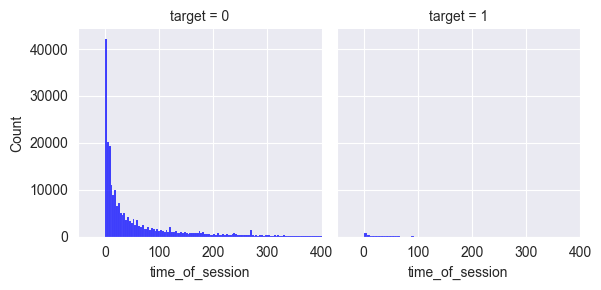

In [7]:
plot = sns.FacetGrid(features, col = 'target')
plot.map(sns.histplot, 'time_of_session', color = 'blue')
plt.xlim(-50, 400)

Text(0.5, 1.0, 'Target = 1')

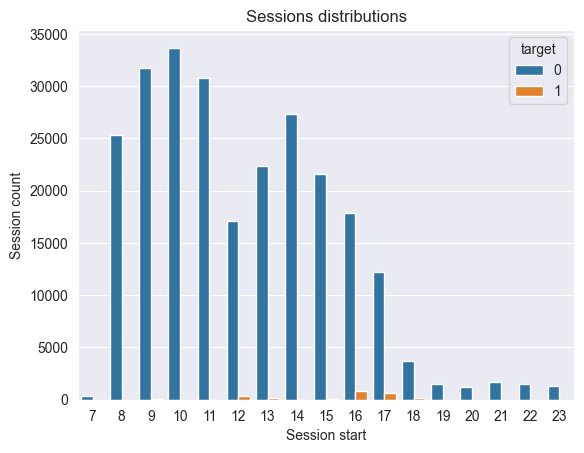

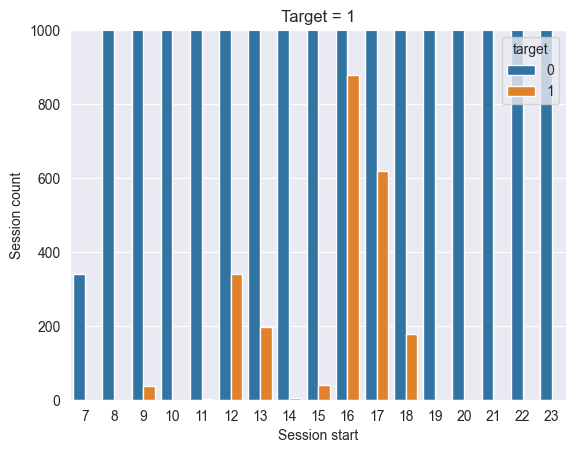

In [8]:
plt.figure()
sns.countplot(x = features['hour'], data = features, hue = 'target')
plt.ylabel('Session count')
plt.xlabel('Session start')
plt.title('Sessions distributions')

plt.figure()
sns.countplot(x = features['hour'], data = features, hue = 'target')
plt.ylim(0, 1000)
plt.ylabel('Session count')
plt.xlabel('Session start')
plt.title('Target = 1')

Text(0.5, 1.0, 'Target = 1')

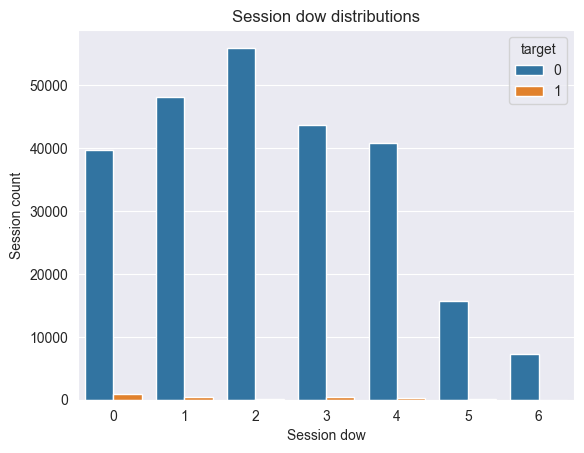

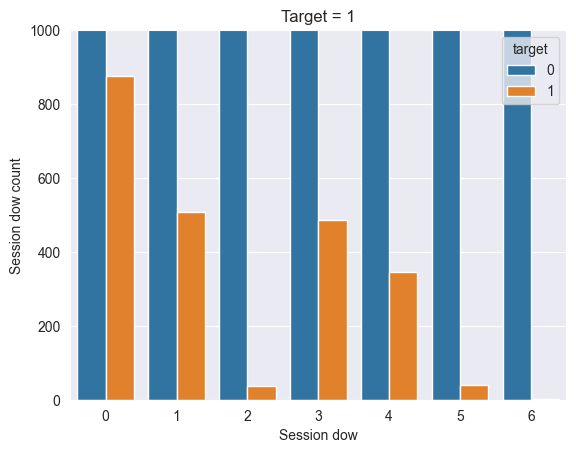

In [9]:
plt.figure()
sns.countplot(x = features['dow'], data = features, hue = 'target')
plt.ylabel('Session count')
plt.xlabel('Session dow')
plt.title('Session dow distributions')

plt.figure()
plt.ylim(0, 1000)
sns.countplot(x = features['dow'], data = features, hue = 'target')
plt.ylabel('Session dow count')
plt.xlabel('Session dow')
plt.title('Target = 1')

Text(0.5, 1.0, 'Target = 1')

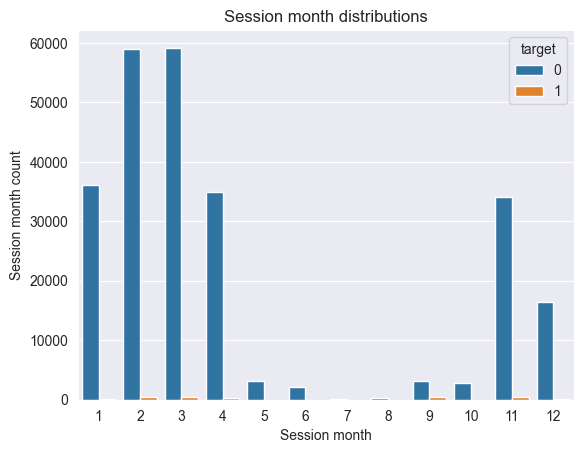

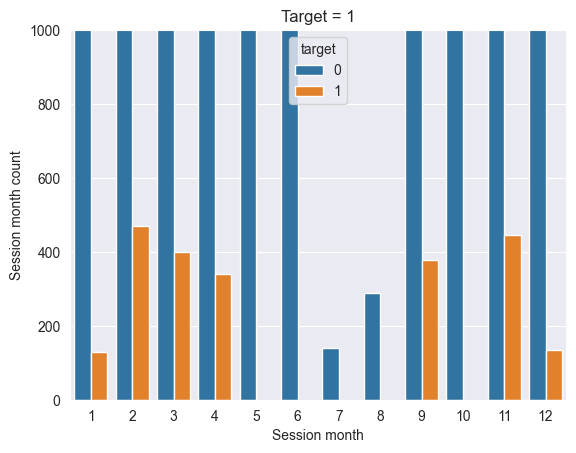

In [10]:
plt.figure()
sns.countplot(x = features['month'], data = features, hue = 'target')
plt.ylabel('Session month count')
plt.xlabel('Session month')
plt.title('Session month distributions')

plt.figure()
plt.ylim(0, 1000)
sns.countplot(x = features['month'], data = features, hue = 'target')
plt.ylabel('Session month count')
plt.xlabel('Session month')
plt.title('Target = 1')

In [11]:
def preprocessing_data(raw_data : pd.DataFrame) -> pd.DataFrame:
    _test = pd.DataFrame()
    sites = raw_data[['site%s' % i for i in range(1,11)]].fillna(0).astype(int).values
    times = raw_data[['time%s' % i for i in range(1,11)]]
    
    for td_index in range(1, 10):
        _test['target'] = raw_data['target']
        _test['time_diff{}'.format(td_index)] = (pd.to_datetime(times['time{}'.format(td_index + 1)]) - pd.to_datetime(times['time{}'.format(td_index)])).dt.total_seconds().fillna(0)
        
    _test['time_of_session'] = np.sum(_test, axis = 1)
    _test['hour'] = pd.to_datetime(times['time1']).dt.hour
    _test['dow'] = pd.to_datetime(times['time1']).dt.dayofweek
    _test['month'] = pd.to_datetime(times['time1']).dt.month
    _test['unique_sites'] = [len([np.unique(session[session != 0])]) for session in sites]
    
    _test['target_hour'] = np.where( ( (_test['hour'] >= 12) & (_test['hour'] <= 13) ) | ( (_test['hour'] >= 16) & (_test['hour'] <= 18)) , 1 , 0)

    _test['target_dow'] = np.where( ((_test['dow'] == 5) | (_test['dow'] == 6) ), 1, 0)
    
    _test['target_month'] = np.where( (_test['month'] >= 5) | (_test['month'] <= 8), 0, 1)    
    return _test

In [12]:
test = preprocessing_data(train_df)
y = test['target']
test.drop(columns = ['target'], inplace = True)
test

,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,time_of_session,hour,dow,month,unique_sites,target_hour,target_dow,target_month
session_id,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,3,2,1,0,0,0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,23.0,1.0,26.0,11,5,2,1,0,1,0
3,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,7.0,16,0,12,1,1,0,0
4,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,270.0,10,4,3,1,0,0,0
5,137.0,0.0,1.0,0.0,36.0,0.0,0.0,67.0,5.0,246.0,10,4,2,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253557,4.0,5.0,1.0,9.0,3.0,12.0,12.0,12.0,1.0,59.0,10,0,11,1,0,0,0
253558,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,16,1,3,1,1,0,0
253559,7.0,0.0,79.0,1.0,0.0,0.0,0.0,0.0,0.0,87.0,14,3,9,1,0,0,0


In [13]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(test, y, test_size=0.2, random_state=SEED)

# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

params = {
   "loss_function": 'Logloss',
    "eval_metric": 'PRAUC',
    "verbose": 200,
    "random_seed": SEED,
    "depth": 8,
    "learning_rate": 0.05,
    "l2_leaf_reg": 10,
    'class_weights' : [1, 110]
}


cb_1 = CatBoostClassifier(**params)

cb_1.fit(X_train, y_train,
       eval_set = (X_test, y_test),
       use_best_model = True)

0:	learn: 0.8839896	test: 0.8913804	best: 0.8913804 (0)	total: 75.4ms	remaining: 1m 15s
200:	learn: 0.9780586	test: 0.9701893	best: 0.9710737 (177)	total: 6.49s	remaining: 25.8s
400:	learn: 0.9914296	test: 0.9751961	best: 0.9752041 (399)	total: 11.7s	remaining: 17.4s
600:	learn: 0.9965970	test: 0.9774839	best: 0.9774839 (600)	total: 16.9s	remaining: 11.2s
800:	learn: 0.9985889	test: 0.9785060	best: 0.9785184 (798)	total: 22.1s	remaining: 5.48s
999:	learn: 0.9993130	test: 0.9790329	best: 0.9790329 (999)	total: 27.2s	remaining: 0us

bestTest = 0.9790329422
bestIteration = 999



In [14]:
y_pred = cb_1.predict_proba(X_test)[:, 1]
y_pred

array([2.38554381e-05, 4.69044248e-04, 3.83643957e-01, ...,
       1.16643690e-02, 1.34467143e-03, 1.72755507e-08])

In [15]:
catboost_test = (y_pred, y_test)

In [16]:
cb_1.save_model('catboost_model.cbm', format='cbm')

In [17]:
import xgboost as xgb

In [18]:

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    eval_metric="auc",
    scale_pos_weight=110
)

xgb_model.fit(X_train, y_train)
xgb_predicted = xgb_model.predict_proba(X_test)[:, 1]

In [19]:
xgb_predicted_test = (xgb_predicted, y_test)

In [20]:
import lightgbm as lgb

In [21]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42,
    class_weight='balanced'
)
lgb_model.fit(X_train, y_train)

lgb_predict = lgb_model.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 1839, number of negative: 201009
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2592
[LightGBM] [Info] Number of data points in the train set: 202848, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


In [22]:
lgb_pred_test = (lgb_predict, y_test)


In [23]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_model.fit(X_train, y_train)
rf_predicted = rf_model.predict_proba(X_test)[:, 1]

In [24]:
rf_predicted_test = (rf_predicted, y_test)

In [25]:
pred_test_array = [catboost_test, xgb_predicted_test, lgb_pred_test, rf_predicted_test]

models_list = [
    'CatBoostClassifier',
    'XGBoostClassifier',
    'LightGBMClassifier',
    'RandomForestClassifier'
]

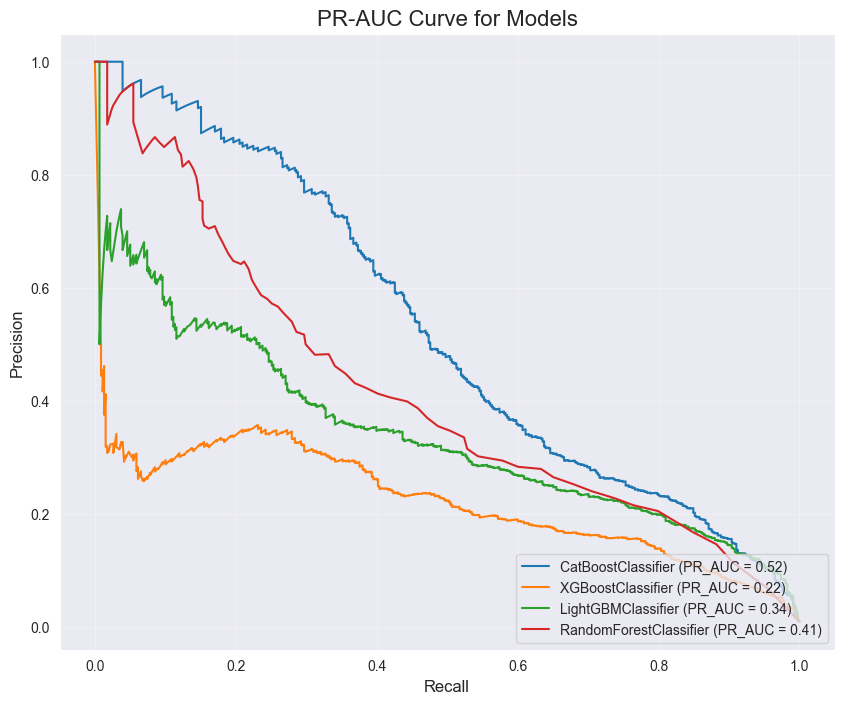

In [26]:
from sklearn.metrics import auc, precision_recall_curve


plt.figure(figsize=(10, 8))
    
for model_name, (y_pred, y_test_) in zip(models_list, pred_test_array):
    precision, recall, _ = precision_recall_curve(y_test_, y_pred)
    roc_auc = auc(recall, precision)  
    plt.plot(recall, precision, label=f'{model_name} (PR_AUC = {roc_auc:.2f})')

plt.title("PR-AUC Curve for Models", fontsize=16)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.show()

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

cat_classes = np.where(y_pred > 0.5, 1, 0)
xgb_classes = np.where(xgb_predicted > 0.5, 1, 0)
lgb_classes = np.where(lgb_predict > 0.5, 1, 0)
rf_classes = np.where(rf_predicted > 0.5, 1, 0)


cat_accuracy = accuracy_score(cat_classes, y_test)
xgb_accuracy = accuracy_score(xgb_classes, y_test)
lgb_accuracy = accuracy_score(lgb_classes, y_test)
rf_accuracy = accuracy_score(rf_classes, y_test)

cat_precision = precision_score(cat_classes, y_test)
xgb_precision = precision_score(xgb_classes, y_test)
lgb_precision = precision_score(lgb_classes, y_test)
rf_precision = precision_score(rf_classes, y_test)

cat_recall = recall_score(cat_classes, y_test)
xgb_recall = recall_score(xgb_classes, y_test)
lgb_recall = recall_score(lgb_classes, y_test)
rf_recall = recall_score(rf_classes, y_test)

cat_f1 = f1_score(cat_classes, y_test)
xgb_f1 = f1_score(xgb_classes, y_test)
lgb_f1 = f1_score(lgb_classes, y_test)
rf_f1 = f1_score(rf_classes, y_test)

results = {
    'accuracy': [cat_accuracy, xgb_accuracy, lgb_accuracy, rf_accuracy],
    'precision' : [cat_precision, xgb_precision, lgb_precision, rf_precision],
    'recall': [cat_recall, xgb_recall, lgb_recall, rf_recall],
    'F1-score' : [cat_f1, xgb_f1, lgb_f1, rf_f1]
}

scores = pd.DataFrame(results, index = ['CatBoost', 'XGBoost', 'LightGBM', 'RandomForest'])
scores

,accuracy,precision,recall,F1-score
CatBoost,0.991817,0.161572,0.704762,0.262877
XGBoost,0.881786,0.938865,0.067219,0.125456
LightGBM,0.941455,0.925764,0.126228,0.222164
RandomForest,0.991817,0.161572,0.704762,0.262877


Text(95.72222222222221, 0.5, 'True Label')

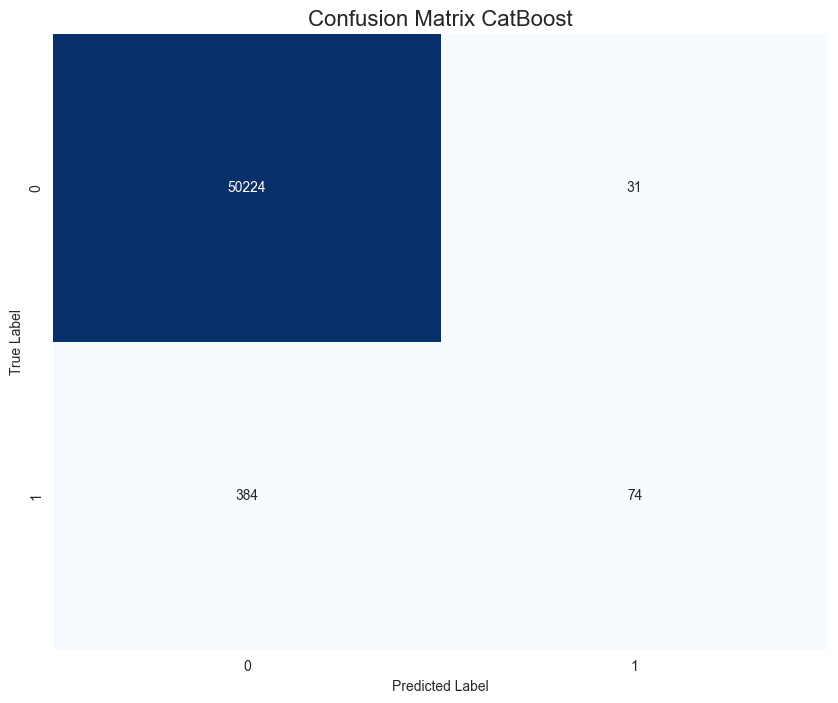

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, cat_classes)

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix CatBoost', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [29]:
y_true = y_test[y_test == 1]
X_true = X_test.loc[y_true.index]

y_proba = cb_1.predict_proba(X_true)[:, 1]

In [30]:
np.where(y_proba > 0.5, 1, 0)

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,

In [31]:
confusion_matrix(y_true, np.where(y_proba > 0.5, 1, 0))

array([[  0,   0],
       [ 84, 374]])

In [32]:
set(xgb_classes)

{0, 1}

In [33]:
recall_score(y_true, np.where(y_proba > 0.5, 1, 0))

0.8165938864628821